In [1]:
import tensorflow as tf
import math
from tqdm import tqdm
import numpy as np
import os
import time
import cv2
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import scipy as scipy
from collections import Counter
from Erosion import crop_rice_grains
import uuid
import gc


from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input,Dense, Conv2D,GlobalAveragePooling2D,Dropout,Flatten,BatchNormalization,Concatenate,InputLayer,AveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import AdamW


%matplotlib inline

2025-03-19 13:12:40.656525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742364760.673431  603705 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742364760.678666  603705 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 13:12:40.698395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, False)
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [
                    tf.config.experimental.VirtualDeviceConfiguration(
                        memory_limit=15288  # set your limit
                    )
                ],
            )
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


I0000 00:00:1742364762.769547  603705 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:02:00.0, compute capability: 8.9


# Initialize Defect Model

In [3]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

config = base_model.get_config()
new_model = tf.keras.models.Model.from_config(config) # <- new_model architecture

x_model = new_model.output
# x_model = data_augmentation(x_model)  
x_model = GlobalAveragePooling2D()(x_model)
x_model = BatchNormalization()(x_model)
x_model = Dropout(0.3)(x_model)
x_model = Dense(128,activation='relu')(x_model)
x_model = BatchNormalization()(x_model)
x_model = Dense(128,activation='relu')(x_model)
x_model = Dropout(0.3)(x_model)
x_model = Dense(64,activation='relu')(x_model)
x_model = Dropout(0.3)(x_model)

predictions = Dense(5, activation='softmax')(x_model)
model = Model(inputs=new_model.input, outputs=predictions)

model.load_weights('/media/new_volumn/MP_DEFECT/models/defect/modelsB0V4.keras')


# Load dataset

In [4]:
def find_npz_files(base_dirs):
    npz_paths = []

    for base_dir in base_dirs:
        for root, dirs, files in os.walk(base_dir):  # Recursively walk through subdirectories
            for file in files:
                if file.endswith('.npz'):  # Check if the file ends with .npz
                    npz_paths.append(os.path.join(root, file))  # Append the full path to the list

    return npz_paths

path_to_hovernet = "/media/nas/MP/segmentation/yolo/"
# List of base folders you want to search through
base_folders = [
    "Mandi_Wise_Scanned_Images/",
    "New Season Paddy  Dec2024/",
    "PNG_Paddy04-2024/",
    "PNG_Paddy07-2024/"
]

all_npz_files = find_npz_files([path_to_hovernet + base_folder for base_folder in base_folders])

In [5]:
len(all_npz_files)

578

In [6]:
def transform(images):
    X_test_resized = tf.image.resize(images['kernel_pics'], (224, 224))

    # # Normalize images to the range [0, 1]
    X_test_normalized = X_test_resized / 255.0

    return np.array(X_test_normalized)

In [7]:
# A set to keep track of generated UUIDs for uniqueness check
generated_uuids = set()

def evaluate(X_test, npz_prefix, npz_filename):

    list_normal_rice = []

    data_dict = [
                    'broke',
                    'dual',
                    'half',
                    'normal',
                    'over'
                ]
    # Perform batch prediction
    Y_pred = model.predict(X_test, verbose=0) 
    y_pred = np.argmax(Y_pred, axis=1)  # Get class indices for the whole batch

    # Set base evaluation directory
    base_dir = "/media/new_volumn/SimDINO/AllIndianDefectsYolo"
    os.makedirs(base_dir, exist_ok=True)

    # Training data directory for embeddings
    training_dir = "/media/new_volumn/SimDINO/images_india_cleaned_yolo/train/"
    os.makedirs(training_dir, exist_ok=True)

    for i, (image, pred_class) in enumerate(zip(X_test, y_pred)):
        class_label = data_dict[pred_class]  # Get class name from index

        # Define directory for defect class
        defect_class_dir = os.path.join(base_dir, class_label)
        os.makedirs(defect_class_dir, exist_ok=True)

        unique_id = uuid.uuid4().hex
        while unique_id in generated_uuids:
            unique_id = uuid.uuid4().hex
        generated_uuids.add(unique_id)

        save_path_defect = os.path.join(defect_class_dir, f"{npz_prefix}_{unique_id}.png")

        # Convert image to NumPy and save
        image_pil = Image.fromarray((image * 255).astype(np.uint8)) 
        image_pil.save(save_path_defect) # save to defect class directory


        if class_label == "normal":
            save_path_training = os.path.join(training_dir, f"{npz_prefix}_{unique_id}.png")
            image_pil.save(save_path_training)
            list_normal_rice.append(image_pil)

    list_normal_rice = np.array(list_normal_rice)




In [8]:
err_count = 0
for count, npz in enumerate(tqdm(all_npz_files, desc="looping through npz")):
    sample_images = np.load(npz)['kernel_pics'].astype('uint8')
    npz_prefix = npz.split("/")[-1][:-4] # obtain the prefix before .npz
    X_test, npz_prefix, err = crop_rice_grains(sample_images, npz_prefix) # apply erosion and dilation, and normalization
    if err: # if error occurs, skip the current npz file
        err_count += 1
        print(f"Error in {npz}, Skipping...")
        continue
    npz_filename = npz.split("/")[-1] # obtain original npz filename
    evaluate(X_test, npz_prefix, npz_filename)

print(f"Number of uncompatible images: {err_count}")
del model
gc.collect()

I0000 00:00:1742364776.162732  604000 service.cc:148] XLA service 0x7f12bc0034b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742364776.162774  604000 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-19 13:12:56.242257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742364776.583946  604000 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-19 13:12:56.698860: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:174236

Unexpected image shape: (0,), the source npz file is IMG_20240223_0001
Error in /media/nas/MP/segmentation/yolo/Mandi_Wise_Scanned_Images/PADDY MANDI 06-10-24/IMG_20240223_0001.npz, Skipping...


looping through npz: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 578/578 [43:54<00:00,  4.56s/it]

Number of uncompatible images: 1


22438

In [42]:
test_file = "npz_india/PUSA_PADDY 1509_HARYANA_ 03.07.2024_20240703_0022.npz"
test_npz = np.load(test_file)

In [ ]:
test_npz['kernel_pics'].shape

(333, 224, 224, 3)

: 

# Statistics

/tmp/ipykernel_603705/803208508.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=classes, y=counts, palette="viridis")


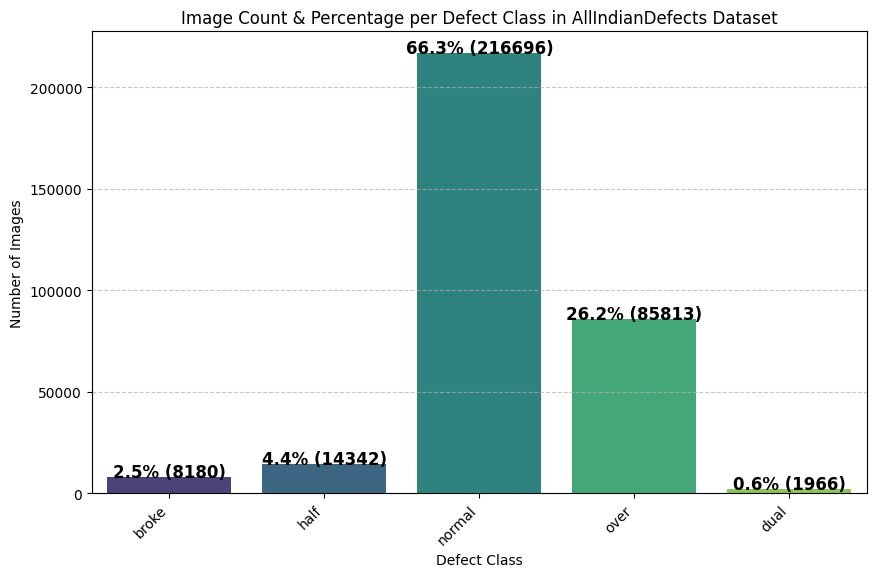

In [10]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dataset path
dataset_path = "AllIndianDefectsYolo/"  # Update this if needed

# Dictionary to store image counts per defect class
class_counts = {}

# Loop through each defect class folder
for defect_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, defect_class)

    if os.path.isdir(class_path):  # Check if it's a folder
        # Count number of image files inside each defect class folder
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        
        # Store the count
        class_counts[defect_class] = num_images

# Convert dictionary to lists for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Calculate total images and percentage for each class
total_images = sum(counts)
percentages = [(count / total_images) * 100 for count in counts]

# Plot the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=classes, y=counts, palette="viridis")

# Add percentage labels on top of each bar
for i, (count, percent) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 1, f"{percent:.1f}% ({count})", ha='center', fontsize=12, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.xlabel("Defect Class")
plt.ylabel("Number of Images")
plt.title("Image Count & Percentage per Defect Class in AllIndianDefects Dataset")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


